# Basic Implicit Rendering

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt

In [3]:
from kaigeo import datasets, nerf_models

In [4]:
device = torch.device('cuda')

In [5]:
from pytorch3d.renderer import (
    FoVPerspectiveCameras,
    look_at_view_transform,
    RayBundle,
    ray_bundle_to_ray_points,
    NDCGridRaysampler,
    EmissionAbsorptionRaymarcher,
    AbsorptionOnlyRaymarcher,
    ImplicitRenderer
)

In [6]:
# render_size describes the size of both sides of the 
# rendered images in pixels. Since an advantage of 
# Neural Radiance Fields are high quality renders
# with a significant amount of details, we render
# the implicit function at double the size of 
# target images.
render_size = 128
# Our rendered scene is centered around (0,0,0) 
# and is enclosed inside a bounding box
# whose side is roughly equal to 3.0 (world units).
volume_extent_world = 20.0

raysampler_grid = NDCGridRaysampler(
    image_height=render_size,
    image_width=render_size,
    n_pts_per_ray=20,
    min_depth=0.1,
    max_depth=volume_extent_world,
)

raymarcher = EmissionAbsorptionRaymarcher() #AbsorptionOnlyRaymarcher()#AbsorptionRaymarcher()

renderer_grid = ImplicitRenderer(
    raysampler=raysampler_grid, raymarcher=raymarcher,
)

/home/brett/miniconda3/envs/geometry/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811803361/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [7]:
color = torch.rand((3,), requires_grad=True, device=device)

In [8]:
opt = torch.optim.Adam([color], lr=0.1)

In [9]:
def volumetric_function(
    ray_bundle: RayBundle,
    **kwargs):

    rays_points_world = ray_bundle_to_ray_points(ray_bundle)

    rays_densities = torch.sigmoid(
        -100.0 * torch.norm(rays_points_world*radius, dim=-1, keepdim=True))

    rays_features = torch.nn.functional.normalize(
        rays_points_world, dim=-1
    ) * 0.5 + 0.5 
    
    return rays_densities, rays_features

In [10]:
def volumetric_function_hard(
    ray_bundle: RayBundle,
    **kwargs):

    rays_points_world = ray_bundle_to_ray_points(ray_bundle)       
    rays_densities = torch.where(
        rays_points_world.norm(keepdim=True, dim=-1) > 0.05, 0.0, 1.0)
    
    c = torch.randn_like(rays_points_world) * 0.00 + color
    color_out = torch.sigmoid(c)
    print(color_out.shape)
    return rays_densities, color_out

In [11]:
R, T = look_at_view_transform(
    eye=torch.tensor([[0.1, 0.0, 0.0]]), 
    at = torch.tensor([[0.0, 0.0, 0.0]])
)

target_cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

In [12]:
res, _ = renderer_grid(target_cameras, volumetric_function_hard)

torch.Size([1, 128, 128, 20, 3])


In [17]:
target = torch.tensor([1.0, 1.0, 1.0], device=device)

# try to make it as red as possible
for i in range(100):
    opt.zero_grad()
    res, _ = renderer_grid(target_cameras, volumetric_function_hard)
    img = res[:, :, :, 0:3]
    dist = torch.norm(img - target, dim=-1)
    print(dist.shape)
    print(dist.mean())
    z = (dist.mean()).backward()
    print(color.grad)
    opt.step()

torch.Size([1, 128, 128, 20, 3])
torch.Size([1, 128, 128])
tensor(1.5994, device='cuda:0', grad_fn=<MeanBackward0>)
tensor([-0.0389, -0.0379, -0.0385], device='cuda:0')
torch.Size([1, 128, 128, 20, 3])
torch.Size([1, 128, 128])
tensor(1.5881, device='cuda:0', grad_fn=<MeanBackward0>)
tensor([-0.0417, -0.0406, -0.0412], device='cuda:0')
torch.Size([1, 128, 128, 20, 3])
torch.Size([1, 128, 128])
tensor(1.5754, device='cuda:0', grad_fn=<MeanBackward0>)
tensor([-0.0448, -0.0435, -0.0442], device='cuda:0')
torch.Size([1, 128, 128, 20, 3])
torch.Size([1, 128, 128])
tensor(1.5609, device='cuda:0', grad_fn=<MeanBackward0>)
tensor([-0.0482, -0.0467, -0.0475], device='cuda:0')
torch.Size([1, 128, 128, 20, 3])
torch.Size([1, 128, 128])
tensor(1.5444, device='cuda:0', grad_fn=<MeanBackward0>)
tensor([-0.0518, -0.0502, -0.0510], device='cuda:0')
torch.Size([1, 128, 128, 20, 3])
torch.Size([1, 128, 128])
tensor(1.5256, device='cuda:0', grad_fn=<MeanBackward0>)
tensor([-0.0556, -0.0540, -0.0549], dev

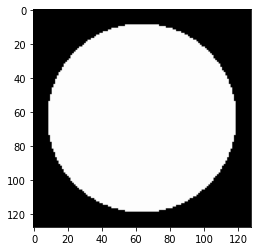

In [18]:
plt.imshow(img[0].detach().cpu().numpy())

# Pytorch is differentiable, so this is also a differentiable renderer

In [122]:
# lets make image brighter.
img.sum().backward()

NameError: name 'img' is not defined